# [F22] Machine Learning Assignment 1  
---

**Student name:** Ozioma Okonicha  
**Submission:** [GitHub repository link](https://github.com/Ozziekins/ML-F22)

## **Cloud Gaming**  

Cloud gaming is a new way of online gaming, which renders the game data on the high-speed cloud server instead of the end user’s system and is forwarded via a high-speed network. However, users do not always have ideal or stable internet for high streaming quality which leads to loss of data packets during data transfer. In this assignment you will use machine learning to detect unstable network which can be used to take steps towards adapting the data streaming and minimizing data packet loss.  



### **Dataset**  

The Datasets comes from Innopolis University partner company providing a cloud gaming service. Each entry of the dataset file is represented by features derived from the five variables. Description of the features can be found in the README file for each dataset. The concrete features in the dataset are derived using statistics such as mean, standard deviation and maximum. The dataset contains numerical and categorical attributes. This format is not very friendly for learning algorithms. Further, we are going to discuss how to preprocess the data before passing it to the ML algorithm.

In [388]:
# all imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import SGDOneClassSVM


In [389]:
# get the dataset from the csv files
bitrate_train_df = pd.read_csv('bitrate_train.csv')
bitrate_test_df = pd.read_csv('bitrate_test.csv')

stream_train_df = pd.read_csv('train_data.csv')
stream_test_df = pd.read_csv('test_data.csv')

In [390]:
# view what our regression dataset looks like
bitrate_train_df.head(5)

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


In [391]:
# view what our classification dataset looks like
stream_train_df.head(5)

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


# **Regression task**
## **Prediction of bitrate**  
---  



In [392]:
# appropriately split the train dataset columns into x and y
bitrate_y_train = bitrate_train_df['target']
bitrate_x_train = bitrate_train_df.drop('target', axis=1)

print("bitrate X train shape : ", bitrate_x_train.shape)
print("bitrate Y train shape : ", bitrate_y_train.shape)

# appropriately split the test dataset columns into x and y
bitrate_y_test = bitrate_test_df['target']
bitrate_x_test = bitrate_test_df.drop('target', axis=1)

print("bitrate X test shape : ", bitrate_x_test.shape)
print("bitrate Y test shape : ", bitrate_y_test.shape)


bitrate X train shape :  (379021, 9)
bitrate Y train shape :  (379021,)
bitrate X test shape :  (228145, 9)
bitrate Y test shape :  (228145,)


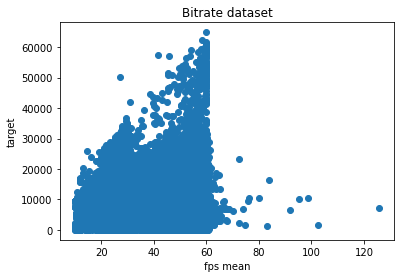

In [393]:
plt.scatter(bitrate_x_train.iloc[:, 0], bitrate_y_train)
plt.title("Bitrate dataset")
plt.xlabel("fps mean")
plt.ylabel("target")
plt.show()

### **Data Preprocessing**  

Data preprocessing is a crucial step in data analysis. The simplest way to convert the string representation into the machine-readable format is to substitute the characters with a unique integer identifier. This can be easily achieved by using Label encoder from sklearn. You are free to apply other ways for handling categorical data. You can explore more encoders from library called [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html). Some models such as neural networks work best with scaled data, therefore to scale the data as part of the preprocessing stage sklearn provides different methods for scaling the data (i.e Standard scaler, [Min-Max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))

In [394]:
# count the number of NaN values in each column to see if there are any
print("NaN values count :- ", np.isnan(bitrate_x_train).sum())

NaN values count :-  fps_mean               0
fps_std                0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
bitrate_mean           0
bitrate_std            0
dtype: int64


In [395]:
# standardize the data features using standard scaler
scaler = StandardScaler()
scaler.fit(bitrate_x_train)
scaled_data = scaler.transform(bitrate_x_train)
scaled_test_data = scaler.transform(bitrate_x_test)

### **Feature Selection**  

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. Methods such as Lasso have feature selection embedded to their algorithm. However there exist other methods which result in improved model prediction performance (i.e statistical based). For feature selection in this assignment you will have to use one of the methods introduced in the labs or Lecture.

Feature 0: 15920.373908
Feature 1: 1707.457849
Feature 2: 3833.285589
Feature 3: 361.600044
Feature 4: 403.238181
Feature 5: 746.650342
Feature 6: 775.739530
Feature 7: 3168868.682680
Feature 8: 140064.663634


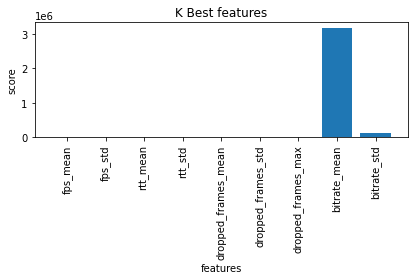

In [396]:
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(scaled_data, bitrate_y_train)

# transform train input data
X_train_fs = fs.transform(scaled_data)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar(["fps_mean", "fps_std", "rtt_mean", "rtt_std", "dropped_frames_mean", 
            "dropped_frames_std", "dropped_frames_max", "bitrate_mean", "bitrate_std"], fs.scores_)
plt.title("K Best features")
plt.xlabel("features")
plt.ylabel("score")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### **Data Visualization**  

For data visualization on 2D plane dimension reduction methods such as Principal component analysis (PCA) can be used. The simplest way is to select one meaningful feature and plot it against the target variable. We suggest plotting the independent variables against the dependent variables. To better understand the data and create the data profile you can use pandas-profiling, which will generate report one line of code.

In [397]:
# UNCOMMENT THE NEXT LINE AND RUN THIS CELL TO BE ABLE TO USE pandas-profiling
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [398]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(bitrate_train_df, title='Bitrate', html={'style':{'full_width':True}})

In [399]:
# profile.to_notebook_iframe()

In [400]:
# profile.to_file(output_file="bitrate_profile.html")

In [401]:
# reduce the dimentionality to visualize on a 2D plane
pca = PCA(n_components=1)
bitrate_x_train_reduced = pca.fit_transform(X_train_fs)
bitrate_x_test_reduced = pca.transform(bitrate_x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


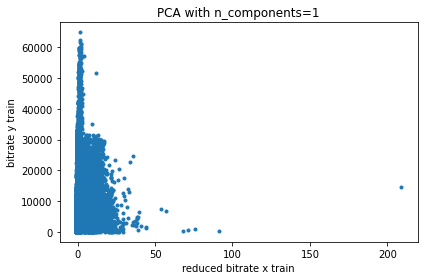

In [402]:
# plot the basis
plt.scatter(bitrate_x_train_reduced, bitrate_y_train, marker='.')
plt.title("PCA with n_components=1")
plt.xlabel("reduced bitrate x train")
plt.ylabel("bitrate y train")
plt.tight_layout()
plt.show()

In [403]:
print(pca.components_)

[[0.13852157 0.36313011 0.10161672 0.12032464 0.45917022 0.53961635
  0.54319352 0.08989025 0.13777431]]


In [404]:
print("Mean : ", pca.mean_)
print("Explained variance : ", pca.explained_variance_)
print("Explained variance ratio: ", pca.explained_variance_ratio_)


Mean :  [ 1.50874172e-16  2.39359024e-16  3.05947624e-17  1.30477663e-17
  2.86450962e-17 -8.15860331e-17 -3.57688767e-17 -1.04382131e-16
 -1.60022605e-16]
Explained variance :  [2.96456914]
Explained variance ratio:  [0.3293957]


### **Machine Learning Models**  

For the regression task (prediction of bitrate), you will need to select the appropriate machine learning algorithm. From the Course of machine learning, you have studied several machine learning algorithms (i.e linear regression, logistic regression, polynomial regression, etc.). If you decide to use an algorithm taking one variable as input, RTT or FPS related feature should be used as an independent (predictor) variable. A minimum of 3 machine learning algorithms should be used for the prediction of bitrate. One of the algorithms should have regularization.

### Linear Regression

In [405]:
# create a linear regression estimator and fit it to our processed data
linear_regression = LinearRegression()
linear_regression.fit(X_train_fs, bitrate_y_train)

linear_score = cross_val_score(linear_regression, scaled_test_data, bitrate_y_test, cv=5)
print(linear_score)

[0.90626203 0.88264286 0.87499521 0.89220649 0.88861733]


### Polynomial Regression

In [406]:
# create a polynomial regression estimator and fit it to our processed data

degree = 2

polynomial_features = PolynomialFeatures(degree=degree,
                                            include_bias=False, )
linear_regression_poly = LinearRegression()

# create our estimator pipeline
poly_pipeline = Pipeline([("polynomial_features", polynomial_features),
                        ("linear_regression", linear_regression_poly)])
poly_pipeline.fit(X_train_fs, bitrate_y_train)
    
poly_score = cross_val_score(poly_pipeline, scaled_test_data, bitrate_y_test, cv=5)
print(poly_score)

[0.90652153 0.88279805 0.87472943 0.89324391 0.88966592]


### SGD Regression

In [407]:
# create a stochastic gradient descent estimator and fit it to our processed data
sgd_regressor = SGDRegressor(penalty="l1")
sgd_regressor.fit(X_train_fs, bitrate_y_train)

sgd_score = cross_val_score(sgd_regressor, scaled_test_data, bitrate_y_test, cv=5)
print(sgd_score)

[0.90584073 0.88218345 0.87428171 0.89070572 0.8885124 ]


### Cross Validation

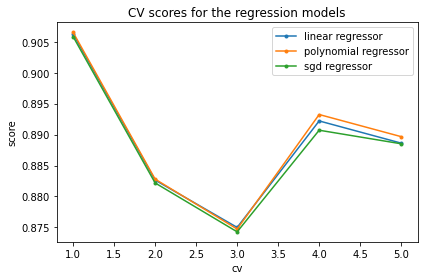

In [408]:
plt.plot([i for i in range(1, 6)], linear_score, marker=".")
plt.plot([i for i in range(1, 6)], poly_score, marker=".")
plt.plot([i for i in range(1, 6)], sgd_score, marker=".")
plt.title("CV scores for the regression models")
plt.legend(["linear regressor", "polynomial regressor", "sgd regressor"])
plt.xlabel("cv")
plt.ylabel("score")
plt.tight_layout()
plt.show()

### **Performance Measurement**  

To measure the performance of the selected models there, exist a number of metrics studied in the course of machine learning (i.e. MSE, precision, recall, RMSE, F1-score, and weighted F1-score). Compare the trained machine learning models in regression task using the appropriate metrics (use minimum of two metrics).

### Mean squared error

MSE for Linear Regression:  3798252.2087928024
MSE for Polynomial Regression:  3775620.26119647
MSE for SGD Regressor:  3826342.088961449


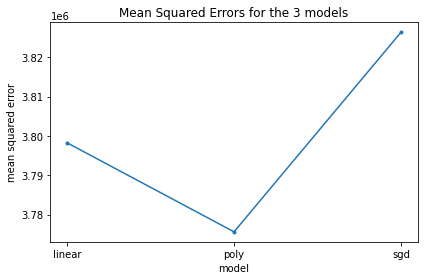

In [409]:
# create a list for all the MSEs
MSEs = []

# calculate and print the mean squared error for the 3 models
bitrate_y_pred = linear_regression.predict(scaled_test_data)
mse = mean_squared_error(bitrate_y_test, bitrate_y_pred)
MSEs.append(mse)
print("MSE for Linear Regression: ", mse)

bitrate_y_pred = poly_pipeline.predict(scaled_test_data)
mse = mean_squared_error(bitrate_y_test, bitrate_y_pred)
MSEs.append(mse)
print("MSE for Polynomial Regression: ", mse)

bitrate_y_pred = sgd_regressor.predict(scaled_test_data)
mse = mean_squared_error(bitrate_y_test, bitrate_y_pred)
MSEs.append(mse)
print("MSE for SGD Regressor: ", mse)

plt.plot(["linear", "poly", "sgd"], MSEs, marker=".")
plt.title("Mean Squared Errors for the 3 models")
plt.xlabel("model")
plt.ylabel("mean squared error")
plt.tight_layout()
plt.show()

### Mean absolute error

MAE for Linear Regression:  1076.8265007157565
MAE for Polynomial Regression:  1052.1454616456333
MSE for SGD Regressor:  1067.2710548019847


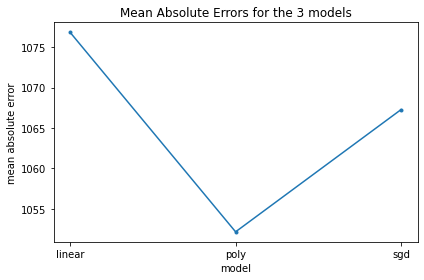

In [410]:
# create a list for all the MAEs
MAEs = []

# calculate and print the mean absolute error for the 3 models
bitrate_y_pred = linear_regression.predict(scaled_test_data)
mae = mean_absolute_error(bitrate_y_test, bitrate_y_pred)
MAEs.append(mae)
print("MAE for Linear Regression: ", mae)

bitrate_y_pred = poly_pipeline.predict(scaled_test_data)
mae= mean_absolute_error(bitrate_y_test, bitrate_y_pred)
MAEs.append(mae)
print("MAE for Polynomial Regression: ", mae)

bitrate_y_pred = sgd_regressor.predict(scaled_test_data)
mae = mean_absolute_error(bitrate_y_test, bitrate_y_pred)
MAEs.append(mae)
print("MSE for SGD Regressor: ", mae)

plt.plot(["linear", "poly", "sgd"], MAEs, marker=".")
plt.title("Mean Absolute Errors for the 3 models")
plt.xlabel("model")
plt.ylabel("mean absolute error")
plt.tight_layout()
plt.show()

### R-Squared Score

R2 for Linear Regression:  0.8934890529608464
R2 for Polynomial Regression:  0.8941237001720678
R2 for SGD Regressor:  0.8927013538891383


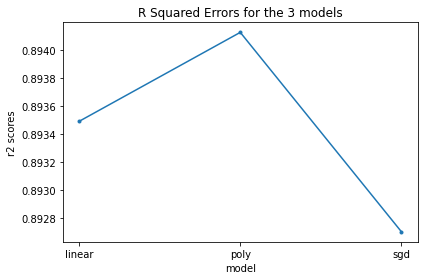

In [411]:
# create a list for all the R2s
R2s = []

# calculate and print the r squared error for the 3 models
bitrate_y_pred = linear_regression.predict(scaled_test_data)
r2 = r2_score(bitrate_y_test, bitrate_y_pred)
R2s.append(r2)
print("R2 for Linear Regression: ", r2)

bitrate_y_pred = poly_pipeline.predict(scaled_test_data)
r2 = r2_score(bitrate_y_test, bitrate_y_pred)
R2s.append(r2)
print("R2 for Polynomial Regression: ", r2)

bitrate_y_pred = sgd_regressor.predict(scaled_test_data)
r2 = r2_score(bitrate_y_test, bitrate_y_pred)
R2s.append(r2)
print("R2 for SGD Regressor: ", r2)

plt.plot(["linear", "poly", "sgd"], R2s, marker=".")
plt.title("R Squared Errors for the 3 models")
plt.xlabel("model")
plt.ylabel("r2 scores")
plt.tight_layout()
plt.show()

# **Classification task**
## **Detection of stream quality**  
---  



In [412]:
# appropriately split the train dataset columns into x and y
stream_y_train = stream_train_df['stream_quality']
stream_x_train = stream_train_df.drop('stream_quality', axis=1)

print("stream X train shape : ", stream_x_train.shape)
print("stream Y train shape : ", stream_y_train.shape)

# appropriately split the test dataset columns into x and y
stream_y_test = stream_test_df['stream_quality']
stream_x_test = stream_test_df.drop('stream_quality', axis=1)

print("stream X test shape : ", stream_x_test.shape)
print("stream Y test shape : ", stream_y_test.shape)


stream X train shape :  (406572, 11)
stream Y train shape :  (406572,)
stream X test shape :  (243596, 11)
stream Y test shape :  (243596,)


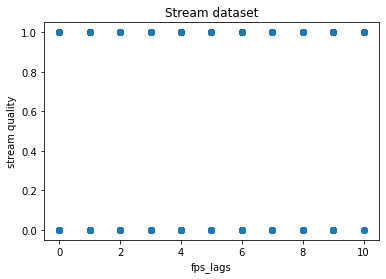

In [413]:
plt.scatter(stream_x_train.iloc[:, 2], stream_y_train)
plt.title("Stream dataset")
plt.xlabel("fps_lags")
plt.ylabel("stream quality")
plt.show()


### **Data Preprocessing**  

Data preprocessing is a crucial step in data analysis. The simplest way to convert the string representation into the machine-readable format is to substitute the characters with a unique integer identifier. This can be easily achieved by using Label encoder from sklearn. You are free to apply other ways for handling categorical data. You can explore more encoders from library called [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html). Some models such as neural networks work best with scaled data, therefore to scale the data as part of the preprocessing stage sklearn provides different methods for scaling the data (i.e Standard scaler, [Min-Max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))

In [414]:
# select all the categorical/object features
stream_objList = stream_x_train.select_dtypes(include = "object").columns

# convert the above objList features into numeric type
# Label Encoding for object to numeric conversion
encoder = LabelEncoder()

for feature in stream_objList:
    stream_x_train[feature] = encoder.fit_transform(stream_x_train[feature].astype(str))
    stream_x_test[feature] = encoder.transform(stream_x_test[feature].astype(str))


In [415]:
# count the number of NaN values in each column to see if there are any
print("NaN values count :- ", np.isnan(stream_x_train).sum())

NaN values count :-  fps_mean               0
fps_std                0
fps_lags               0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
auto_bitrate_state     0
auto_fec_state         0
auto_fec_mean          0
dtype: int64


In [416]:
# standardize the data features using standard scaler
scaler = StandardScaler()
scaler.fit(stream_x_train)
scaled_data = scaler.transform(stream_x_train)
scaled_test_data = scaler.transform(stream_x_test)

### **Feature Selection**  

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. Methods such as Lasso have feature selection embedded to their algorithm. However there exist other methods which result in improved model prediction performance (i.e statistical based). For feature selection in this assignment you will have to use one of the methods introduced in the labs or Lecture.

Feature 0: 13504.447573
Feature 1: 17478.623682
Feature 2: 110414.747363
Feature 3: 3547.471898
Feature 4: 4637.201810
Feature 5: 6931.717620
Feature 6: 1237.386672
Feature 7: 7350.342683
Feature 8: 71.895597
Feature 9: 1620.046968
Feature 10: 399.130039


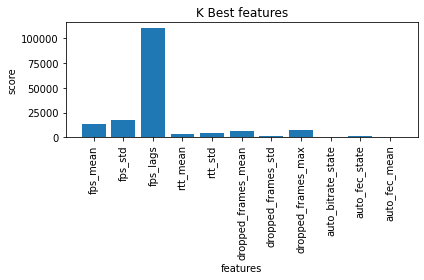

In [417]:
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(scaled_data, stream_y_train)

# transform train input data
X_train_fs = fs.transform(scaled_data)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar(["fps_mean", "fps_std", "fps_lags", "rtt_mean", "rtt_std", "dropped_frames_mean",
         "dropped_frames_std", "dropped_frames_max", "auto_bitrate_state", 
         "auto_fec_state", "auto_fec_mean"], fs.scores_)
plt.title("K Best features")
plt.xlabel("features")
plt.ylabel("score")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### **Data Visualization**  

For data visualization on 2D plane dimension reduction methods such as Principal component analysis (PCA) can be used. The simplest way is to select one meaningful feature and plot it against the target variable. We suggest plotting the independent variables against the dependent variables. To better understand the data and create the data profile you can use pandas-profiling, which will generate report one line of code.

In [418]:
# # from pandas_profiling import ProfileReport

# profile = ProfileReport(stream_train_df, title='Stream Quality', html={'style':{'full_width':True}})

In [419]:
# profile.to_notebook_iframe()

In [420]:
# profile.to_file(output_file="stream_profile.html")

In [421]:
# reduce the dimentionality to visualize on a 2D plane
pca = PCA(n_components=1)
stream_x_train_reduced = pca.fit_transform(X_train_fs)
stream_x_test_reduced = pca.transform(stream_x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


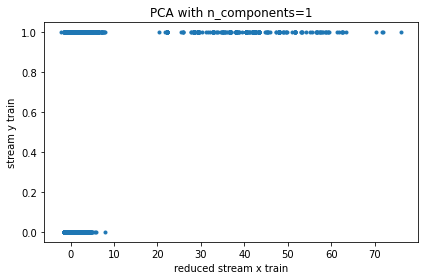

In [422]:
# plot the basis
plt.scatter(stream_x_train_reduced, stream_y_train, marker='.')
plt.title("PCA with n_components=1")
plt.xlabel("reduced stream x train")
plt.ylabel("stream y train")
plt.tight_layout()
plt.show()

In [423]:
print(pca.components_)

[[-0.20796491 -0.0050476   0.37567254  0.0463235   0.06115022  0.55462871
   0.30113618  0.57980733  0.02959799 -0.21197929 -0.17154078]]


In [424]:
print("Mean : ", pca.mean_)
print("Explained variance : ", pca.explained_variance_)
print("Explained variance ratio: ", pca.explained_variance_ratio_)

Mean :  [ 5.40790670e-16  1.55470327e-16 -5.67634467e-17 -3.07585179e-17
  1.42607674e-17 -1.28626530e-17 -7.02552512e-18 -2.37679457e-18
  2.68437975e-17 -3.57917299e-17 -7.95876651e-17]
Explained variance :  [2.44303553]
Explained variance ratio:  [0.22209359]


### **Machine Learning Models**  

For the classification task (detection of stream quality), you will need to select the appropriate machine learning algorithm. From the Course of machine learning, you have studied several machine learning algorithms (i.e Logistic regression). Logistic regression is the minimum machine learning algorithm to be used for the detection of stream quality. Logistic regression should be used with L1 or L2 regularization.

### Naive Bayes

In [425]:
# create a naive bayes classifier and fit it to our processed data
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_fs, stream_y_train)

gaussian_score = cross_val_score(gaussian_nb, scaled_test_data, stream_y_test, cv=5)
print(gaussian_score)

[0.93938834 0.91531025 0.93877132 0.93940762 0.93768345]


### Logistic Regression (with penalty)

In [426]:
# create a logistic regression estimator and fit it to our processed data
logistic_regression_l1 = LogisticRegression(penalty="l1", solver="saga")
logistic_regression_l1.fit(X_train_fs, stream_y_train)

logistic_score = cross_val_score(logistic_regression_l1, scaled_test_data, stream_y_test, cv=5)
print(logistic_score)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[0.94061987 0.93942815 0.9418502  0.93829923 0.93992077]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### SGD Classifier

In [427]:
# create a stochastic gradient descent classification estimator and fit it to our processed data
sgd_classifier = SGDClassifier(penalty="l2", learning_rate="optimal")
sgd_classifier.fit(X_train_fs, stream_y_train)

sgd_score = cross_val_score(sgd_classifier, scaled_test_data, stream_y_test, cv=5)
print(sgd_score)

[0.93928571 0.93809397 0.93944868 0.93727293 0.9382787 ]


### Cross validation 

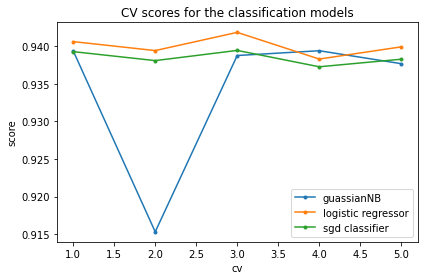

In [428]:
plt.plot([i for i in range(1, 6)], gaussian_score, marker=".")
plt.plot([i for i in range(1, 6)], logistic_score, marker=".")
plt.plot([i for i in range(1, 6)], sgd_score, marker=".")
plt.title("CV scores for the classification models")
plt.legend(["guassianNB", "logistic regressor", "sgd classifier"])
plt.xlabel("cv")
plt.ylabel("score")
plt.tight_layout()
plt.show()

### **Performance Measurement**  

To measure the performance of the selected models there, exist a number of metrics studied in the course of machine learning (i.e. MSE, precision, recall, RMSE, F1-score, and weighted F1-score). Compare the trained machine learning models in classification task using the appropriate metrics (use minimum of two metrics).

### Precision

Precision score for naive bayes:  0.6320453739808578
Precision score for logistic regression with l1 penalty:  0.7074010327022375
Precision score for sgd classifier:  0.8960396039603961


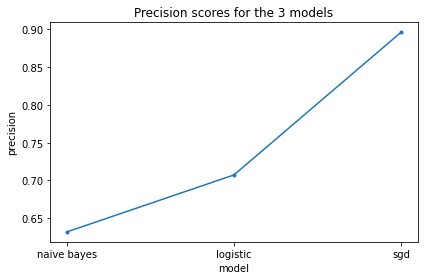

In [429]:
# create a list for all the precision scores
precisions = []

# calculate and print the precisions scores for the 3 models
stream_y_pred = gaussian_nb.predict(scaled_test_data)
precision = precision_score(stream_y_test, stream_y_pred)
precisions.append(precision)
print("Precision score for naive bayes: ", precision)

stream_y_pred = logistic_regression_l1.predict(scaled_test_data)
precision = precision_score(stream_y_test, stream_y_pred)
precisions.append(precision)
print("Precision score for logistic regression with l1 penalty: ", precision)

stream_y_pred = sgd_classifier.predict(scaled_test_data)
precision = precision_score(stream_y_test, stream_y_pred)
precisions.append(precision)
print("Precision score for sgd classifier: ", precision)

plt.plot(["naive bayes", "logistic", "sgd"], precisions, marker=".")
plt.title("Precision scores for the 3 models")
plt.xlabel("model")
plt.ylabel("precision")
plt.tight_layout()
plt.show()

### Recall

Recalls score for naive bayes:  0.11361029692876258
Recalls score for logistic regression with l1 penalty:  0.13094176118261755
Recalls score for sgd classifier:  0.057665349815216004


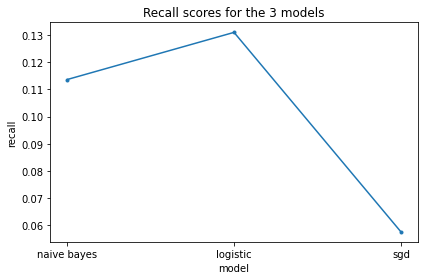

In [430]:
# create a list for all the recalls scores
recalls = []

# calculate and print the recalls scores for the 3 models
stream_y_pred = gaussian_nb.predict(scaled_test_data)
recall = recall_score(stream_y_test, stream_y_pred)
recalls.append(recall)
print("Recalls score for naive bayes: ", recall)

stream_y_pred = logistic_regression_l1.predict(scaled_test_data)
recall = recall_score(stream_y_test, stream_y_pred)
recalls.append(recall)
print("Recalls score for logistic regression with l1 penalty: ", recall)

stream_y_pred = sgd_classifier.predict(scaled_test_data)
recall = recall_score(stream_y_test, stream_y_pred)
recalls.append(recall)
print("Recalls score for sgd classifier: ", recall)

plt.plot(["naive bayes", "logistic", "sgd"], recalls, marker=".")
plt.title("Recall scores for the 3 models")
plt.xlabel("model")
plt.ylabel("recall")
plt.tight_layout()
plt.show()

### Accuracy

Accuracy score for naive bayes:  0.9386319972413341
Accuracy score for logistic regression with l1 penalty:  0.9405203697926074
Accuracy score for sgd classifier:  0.9388577809159427


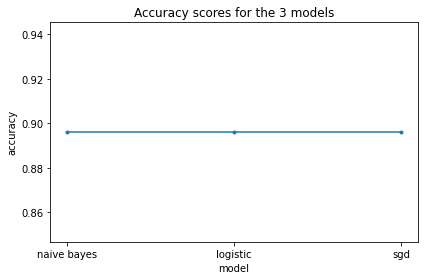

In [431]:
# create a list for all the accuracy scores
accuracies = []

# calculate and print the accuracy scores for the 3 models
stream_y_pred = gaussian_nb.predict(scaled_test_data)
accuracy = accuracy_score(stream_y_test, stream_y_pred)
accuracies.append(precision)
print("Accuracy score for naive bayes: ", accuracy)

stream_y_pred = logistic_regression_l1.predict(scaled_test_data)
accuracy = accuracy_score(stream_y_test, stream_y_pred)
accuracies.append(precision)
print("Accuracy score for logistic regression with l1 penalty: ", accuracy)

stream_y_pred = sgd_classifier.predict(scaled_test_data)
accuracy = accuracy_score(stream_y_test, stream_y_pred)
accuracies.append(precision)
print("Accuracy score for sgd classifier: ", accuracy)

plt.plot(["naive bayes", "logistic", "sgd"], accuracies, marker=".")
plt.title("Accuracy scores for the 3 models")
plt.xlabel("model")
plt.ylabel("accuracy")
plt.tight_layout()
plt.show()

### F1 Score

F1 score for naive bayes:  0.19260059411288144
F1 score for logistic regression with l1 penalty:  0.22097962256035267
F1 score for sgd classifier:  0.10835727969348659


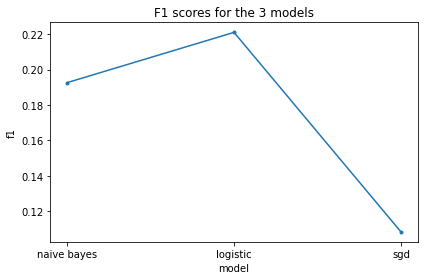

In [432]:
# create a list for all the accuracy scores
f1s = []

# calculate and print the accuracy scores for the 3 models
stream_y_pred = gaussian_nb.predict(scaled_test_data)
f1 = f1_score(stream_y_test, stream_y_pred)
f1s.append(f1)
print("F1 score for naive bayes: ", f1)

stream_y_pred = logistic_regression_l1.predict(scaled_test_data)
f1 = f1_score(stream_y_test, stream_y_pred)
f1s.append(f1)
print("F1 score for logistic regression with l1 penalty: ", f1)

stream_y_pred = sgd_classifier.predict(scaled_test_data)
f1 = f1_score(stream_y_test, stream_y_pred)
f1s.append(f1)
print("F1 score for sgd classifier: ", f1)

plt.plot(["naive bayes", "logistic", "sgd"], f1s, marker=".")
plt.title("F1 scores for the 3 models")
plt.xlabel("model")
plt.ylabel("f1")
plt.tight_layout()
plt.show()

### **Data Balancing and Outlier Detection**  

The classification task dataset is imbalanced and contains outliers. This possess threat to the learning and performance of the ML model. There exist different ways to balance the dataset and remove outliers. The main task is to select one data balancing approach from literature, remove outliers using an approach from literature, balance the data and evaluate the impact of balancing the data on one the model used in the classification task. For a start you can explore [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) and [1, 2, 3, 4]

In [433]:
# create an sgd outlier detector and fit it to our processed data

oneclass_svm = SGDOneClassSVM()
outlier_map = oneclass_svm.fit_predict(X_train_fs)
outlier_map

array([-1, -1,  1, ..., -1, -1, -1], dtype=int32)

In [434]:
# fetch the indexes that are equal to 1 (not outliers)
indexes = [i for i in outlier_map if outlier_map[i] == 1]

# cherry pick just the non outliers using the retrieved indexes
balanced_x_train = X_train_fs[outlier_map == 1]
balanced_y_train = stream_y_train[outlier_map == 1]

In [435]:
# create a logistic regression estimator and fit it to
# our newly balanced data
logistic_regressor_balanced = LogisticRegression(penalty="l1", solver="saga")
logistic_regressor_balanced.fit(X_train_fs, stream_y_train)

LogisticRegression(penalty='l1', solver='saga')

In [436]:
# calculate the metrics again on the balanced dataset
stream_y_pred = logistic_regressor_balanced.predict(scaled_test_data)
balanced_precision = precision_score(stream_y_test, stream_y_pred)
print("Precision score for logistic regression with l1 penalty: ", balanced_precision)

balanced_recall = recall_score(stream_y_test, stream_y_pred)
print("Recall score for logistic regression with l1 penalty: ", balanced_recall)

balanced_accuracy = accuracy_score(stream_y_test, stream_y_pred)
print("Accuracy score for logistic regression with l1 penalty: ", balanced_accuracy)

balanced_f1 = f1_score(stream_y_test, stream_y_pred)
print("F1 score for logistic regression with l1 penalty: ", balanced_f1)

Precision score for logistic regression with l1 penalty:  0.7074010327022375
Recall score for logistic regression with l1 penalty:  0.13094176118261755
Accuracy score for logistic regression with l1 penalty:  0.9405203697926074
F1 score for logistic regression with l1 penalty:  0.22097962256035267


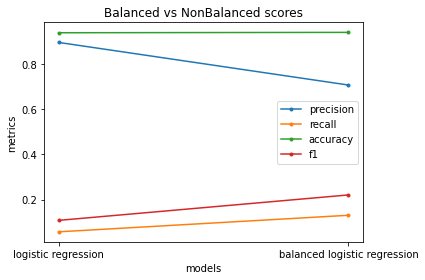

In [437]:
plt.plot(["logistic regression", "balanced logistic regression"], [precision, balanced_precision], marker=".")
plt.plot(["logistic regression", "balanced logistic regression"], [recall, balanced_recall], marker=".")
plt.plot(["logistic regression", "balanced logistic regression"], [accuracy, balanced_accuracy], marker=".")
plt.plot(["logistic regression", "balanced logistic regression"], [f1, balanced_f1], marker=".")
plt.legend(["precision", "recall", "accuracy", "f1"])
plt.title("Balanced vs NonBalanced scores")
plt.xlabel("models")
plt.ylabel("metrics")
plt.tight_layout()
plt.show()